Attempt to use clustering algorithm DBSCAN from scikit-learn to perform track detection   
Consider implementing PYROOT to avoid extra ROOT scripting and csv reading steps   
Note on DBSCAN algorithm: finds clusters, not tracks (eg. two overlapping tracks = one cluster)

In [2]:
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

#import ROOT


In [114]:
# roi_efficiency calculates efficiency from orig and roi data files given a file header
# eg. (efficiency_bin, efficiency_weight) = roi_efficiency('hu_gauss1')
def roi_efficiency(filename_header, save_plots=True, show_plots=False):

    # Get data from csv
    filename = filename_header + '_orig.csv'
    filename_roi = filename_header + '_roi.csv'
    data = np.genfromtxt(filename, delimiter=',')
    data_roi = np.genfromtxt(filename_roi, delimiter=',')

    X = data[2:,0:2]
    weight = data[2:,2]
    xrange = np.ceil(data[:2,0])
    yrange = data[:2,1]
    
    X_roi = data_roi[2:,0:2]
    weight_roi = data_roi[2:,2]
    xrange_roi = np.ceil(data_roi[:2,0])
    yrange_roi = data_roi[:2,1]
    
    # shift xbin indices so they're equivalent 
    if (xrange[0] != xrange_roi[0]) or (yrange[0] != yrange_roi[0]):
        xshift = xrange_roi[0] - xrange[0]
        yshift = yrange_roi[0] - yrange[0]
        X_roi = np.stack((X_roi[:,0]+xshift, X_roi[:,1]+yshift), axis=-1)

    # #############################################################################
    # Compute DBSCAN

    # Set parameters
    eps = 5
    min_samples = 1

    # Perform DBSCAN fit
    db = DBSCAN(eps, min_samples).fit(X, sample_weight=weight)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_, '\n')
    
    # Remove noise   ## TODO: there's no noise anymore, all points are included
    X_no_noise = X[labels!=-1]
    weight_no_noise = weight[labels!=-1]
    labels_no_noise = labels[labels!=-1]

    # #############################################################################
    # Differentiate track-like and point-like clusters

    xspan_thresh = 10
    yspan_thresh = 200
    track_labels = []
    point_labels = []

    for i in range(np.max(labels)+1):
        cluster_i = X_no_noise[labels_no_noise == i]

        # tag point-like clusters
        xspan = np.max(cluster_i[:,0]) - np.min(cluster_i[:,0])
        yspan = np.max(cluster_i[:,1]) - np.min(cluster_i[:,1])

        if (xspan < xspan_thresh) and (yspan < yspan_thresh):
            point_labels = np.append(point_labels, i)
        else:
            track_labels = np.append(track_labels, i)

    point_samples = [label in point_labels for label in labels_no_noise]
    track_samples = [label in track_labels for label in labels_no_noise]

    n_point_clusters = len(set(labels_no_noise[point_samples]))
    n_track_clusters = len(set(labels_no_noise[track_samples]))

    # #############################################################################
    # Find intersect between orig and roi

    n_samples_no_noise = np.shape(X_no_noise)[0]

    #print("n bins total: ", len(weight))
    #print("weight total: ", sum(weight))
    #print("bin proportion without noise: ", len(weight_no_noise)/len(weight))
    #print("weight proportion without noise: ", sum(weight_no_noise)/sum(weight), "\n")

    i_roi = 0
    intersect = []

    # loop through X_no_noise and X_roi in tandem, and tag intersection (same points)
    for i in range(n_samples_no_noise):
        xy = X_no_noise[i]
        xy_roi = X_roi[i_roi]

        while ((xy_roi[0] <= xy[0] and xy_roi[1] < xy[1]) or (xy_roi[0] < xy[0])) and (i_roi+1 < np.shape(X_roi)[0]):
            i_roi += 1
            xy_roi = X_roi[i_roi]

        if (xy_roi[0] == xy[0]) and (xy_roi[1] == xy[1]):
            intersect.append(True)
        else:
            intersect.append(False)
            
    intersect = np.array(intersect)
    track_intersect = np.logical_and(intersect, track_samples)
    point_intersect = np.logical_and(intersect, point_samples)
    
    # #############################################################################
    # Check individual clusters
    
    n_track_clusters_counted = n_track_clusters
    n_point_clusters_counted = n_point_clusters
    missed_cluster_labels = []
    poor_cluster_labels = []
    
    # count missed clusters
    for i in set(labels_no_noise):
        labels_i = labels_no_noise==i
        cluster_i = X_no_noise[labels_i]
        weight_i = weight_no_noise[labels_i]
        intersect_i = intersect[labels_i]
        
        efficiency_bin_i = np.sum(intersect_i)/len(cluster_i)
        efficiency_weight_i = np.sum(weight_i[intersect_i])/np.sum(weight_i)
        
        # point-like cluster
        if np.any(np.logical_and(labels_i, point_samples)):
            if not np.any(intersect_i):
                n_point_clusters_counted -= 1
                missed_cluster_labels = np.append(missed_cluster_labels, i)
                #print("***** Missed point-like cluster ", i, "*****")
        # else track-like
        else:
            if not np.any(intersect_i):
                n_track_clusters_counted -= 1
                missed_cluster_labels = np.append(missed_cluster_labels, i)
                print("***** Missed track-like cluster ", i, "*****")
            elif efficiency_weight_i < .90:
                poor_cluster_labels = np.append(poor_cluster_labels, i)
                print("Poor efficiency in cluster ", i)
                print("weight efficiency: ", efficiency_weight_i)
    
    # #############################################################################
    # Compute efficiency
    
    # track efficiency 
    tot_track_bins = len(weight_no_noise[track_samples])
    tot_track_bins_counted = len(weight_no_noise[track_intersect])
    track_eff_bin = tot_track_bins_counted/tot_track_bins
    print("track efficiency (bins): ", track_eff_bin)
    tot_track_weight = sum(weight_no_noise[track_samples])
    tot_track_weight_counted = sum(weight_no_noise[track_intersect])
    track_eff_weight = tot_track_weight_counted/tot_track_weight
    print("track efficiency (weight): ", track_eff_weight)
    print("track efficiency (clusters): ", n_track_clusters_counted/n_track_clusters)

    # point efficiency
    tot_point_bins = len(weight_no_noise[point_samples])
    tot_point_bins_counted = len(weight_no_noise[point_intersect])
    point_eff_bin = tot_point_bins_counted/tot_point_bins
    print("point efficiency (bins): ", point_eff_bin)
    tot_point_weight = sum(weight_no_noise[point_samples])
    tot_point_weight_counted = sum(weight_no_noise[point_intersect])
    point_eff_weight = tot_point_weight_counted/tot_point_weight
    print("point efficiency (weight): ", point_eff_weight)
    print("point efficiency (clusters): ", n_point_clusters_counted/n_point_clusters, "\n")

    # #############################################################################
    # Plot results

    plt.figure(figsize=(20,14))
    plt.xlabel('x bin (channel)')
    plt.ylabel('y bin (time)')

    unique_labels = set(labels_no_noise)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for label, col in zip(unique_labels, colors):
        cluster_mask = (labels_no_noise == label)

        xy = X_no_noise[cluster_mask]
        if (label in missed_cluster_labels) or (label in poor_cluster_labels):
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor='k', markersize=3, markeredgecolor='k')
        else:
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=3)

    plt.title(filename_header + ' clustered')
    
    if save_plots:
        plt.savefig('plots/' + filename_header + '_clusters_orig.png')
    
    if not show_plots:
        plt.close()
        
    # #############################################################################
    # Return results
    
    # [track_bins, track_weight, track_clusters, point_bins, point_weight, point_clusters]
    total_results = [tot_track_bins, tot_track_weight, n_track_clusters, tot_point_bins, tot_point_weight, n_point_clusters]
    cnted_results = [tot_track_bins_counted, tot_track_weight_counted, n_track_clusters_counted, tot_point_bins_counted, tot_point_weight_counted, n_point_clusters_counted]
        
    return total_results, cnted_results



---------------------------------------------------
hv_gauss0 

Estimated number of clusters: 301 

Poor efficiency in cluster  168
weight efficiency:  0.7478278771952551
Poor efficiency in cluster  213
weight efficiency:  0.7381881063768337
track efficiency (bins):  0.9635961253128575
track efficiency (weight):  0.9926733829170261
track efficiency (clusters):  1.0
point efficiency (bins):  0.9499365813623816
point efficiency (weight):  0.9811878954116501
point efficiency (clusters):  0.9265734265734266 

---------------------------------------------------
hv_gauss1 

Estimated number of clusters: 241 

track efficiency (bins):  0.9453017021034894
track efficiency (weight):  0.9741433765275628
track efficiency (clusters):  1.0
point efficiency (bins):  0.8945250579197659
point efficiency (weight):  0.9596820949245849
point efficiency (clusters):  0.8326180257510729 

---------------------------------------------------
hu_gauss3 

Estimated number of clusters: 139 

track efficiency (bi

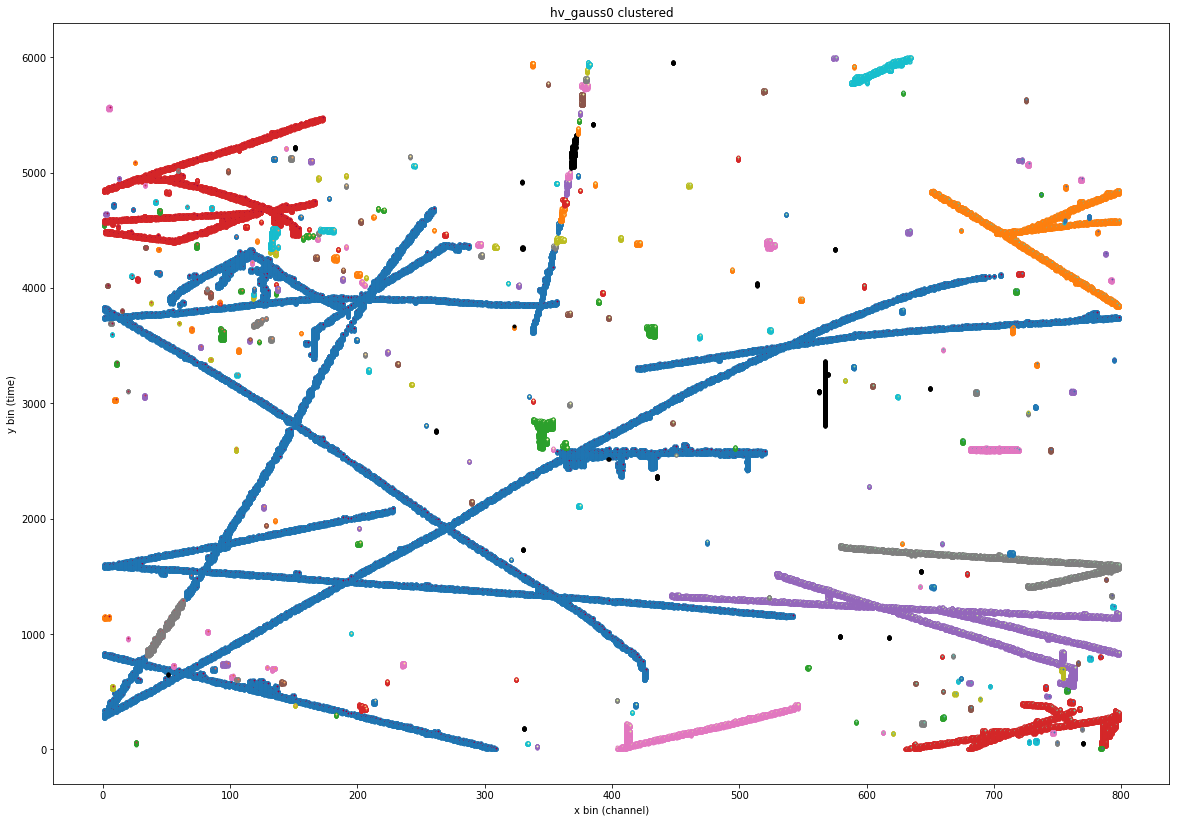

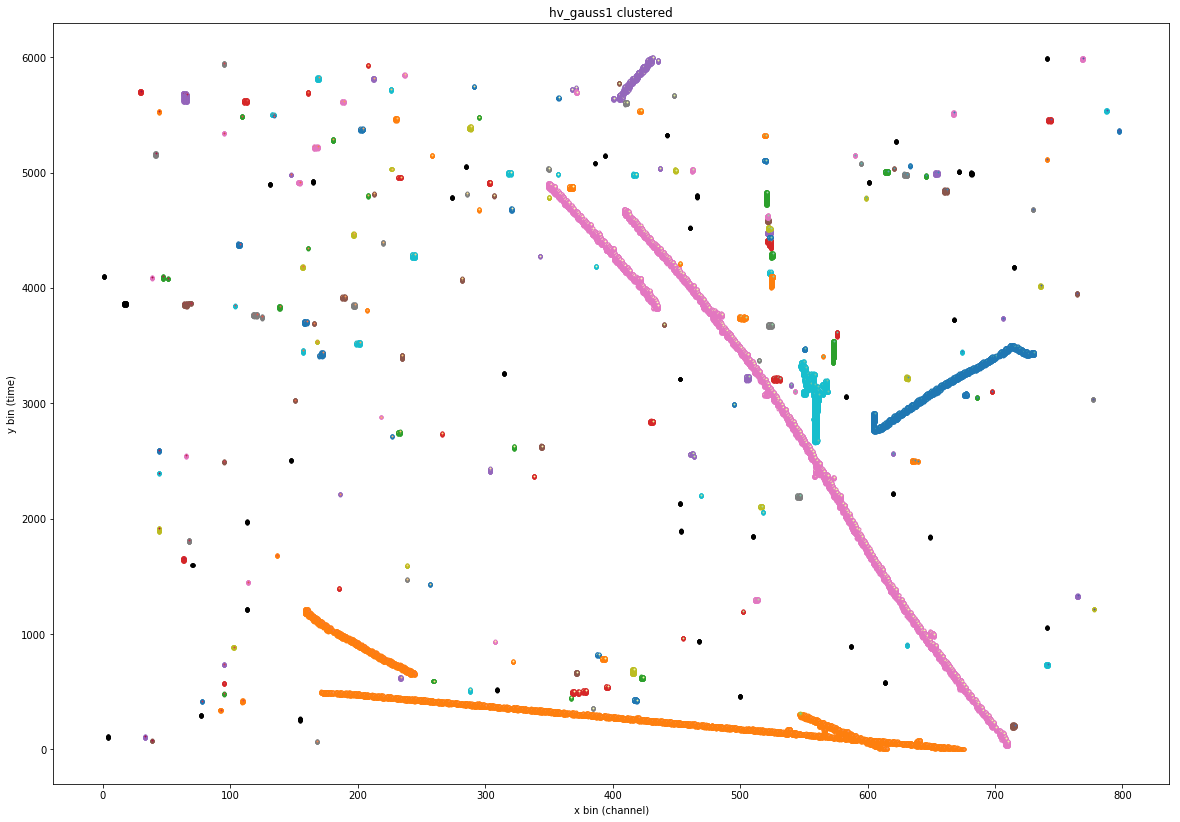

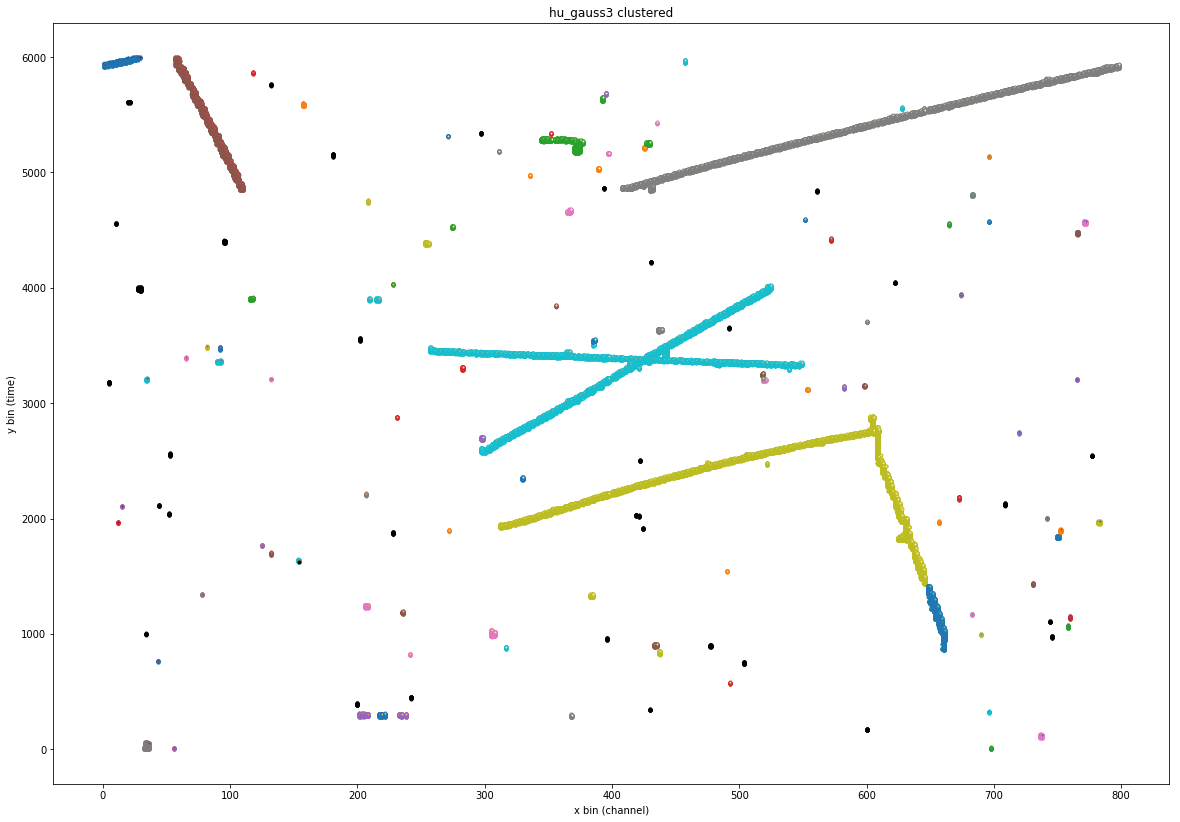

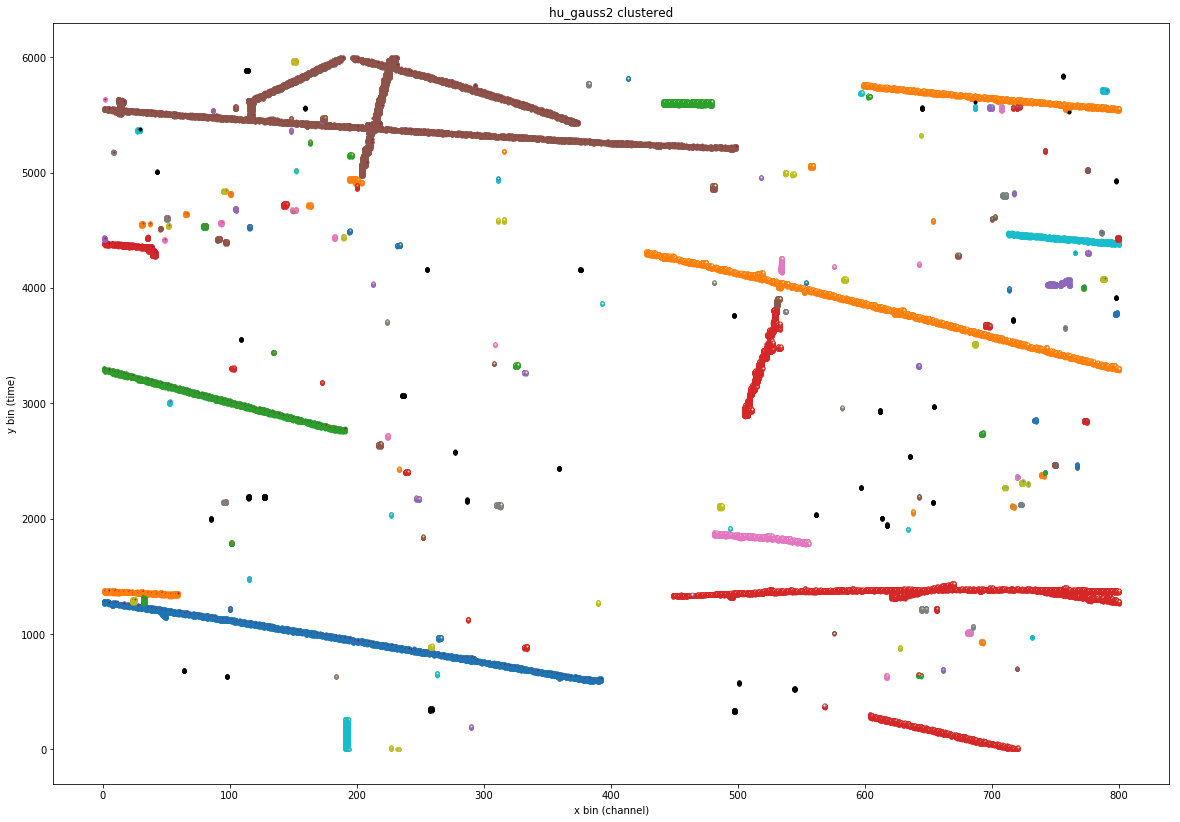

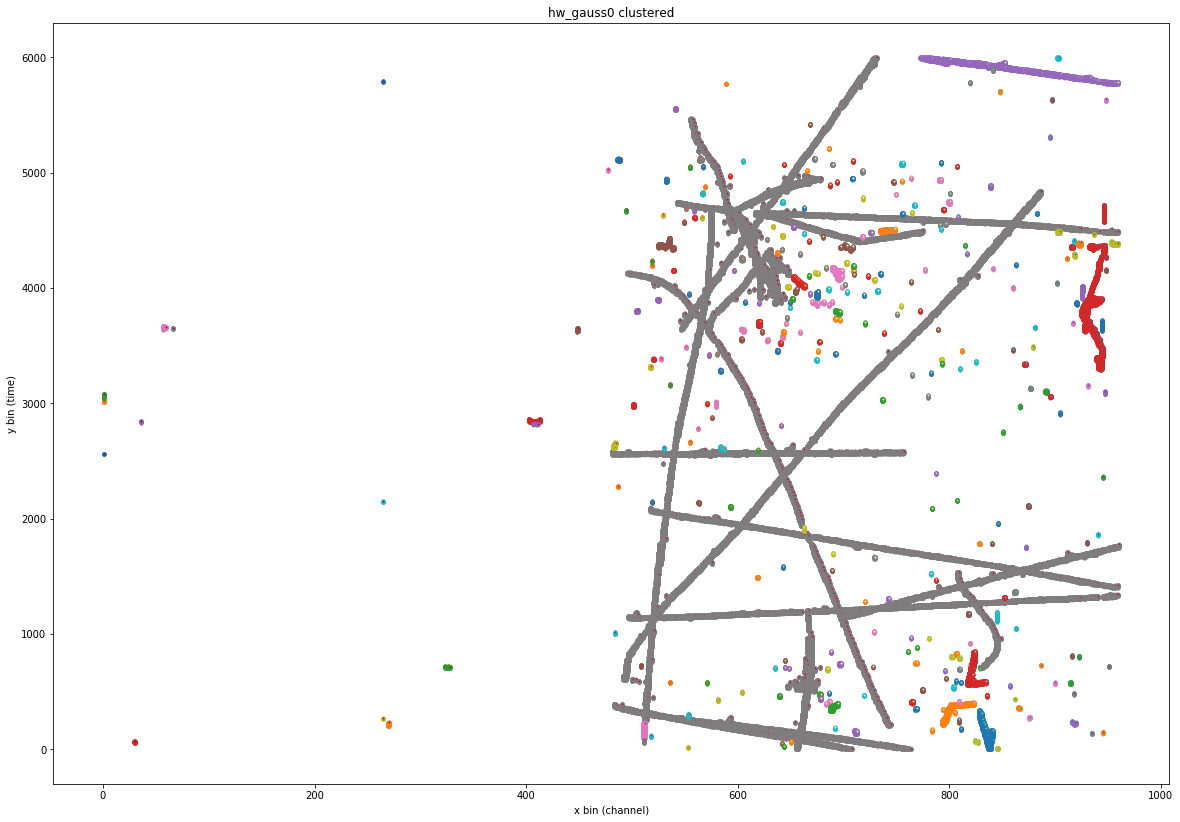

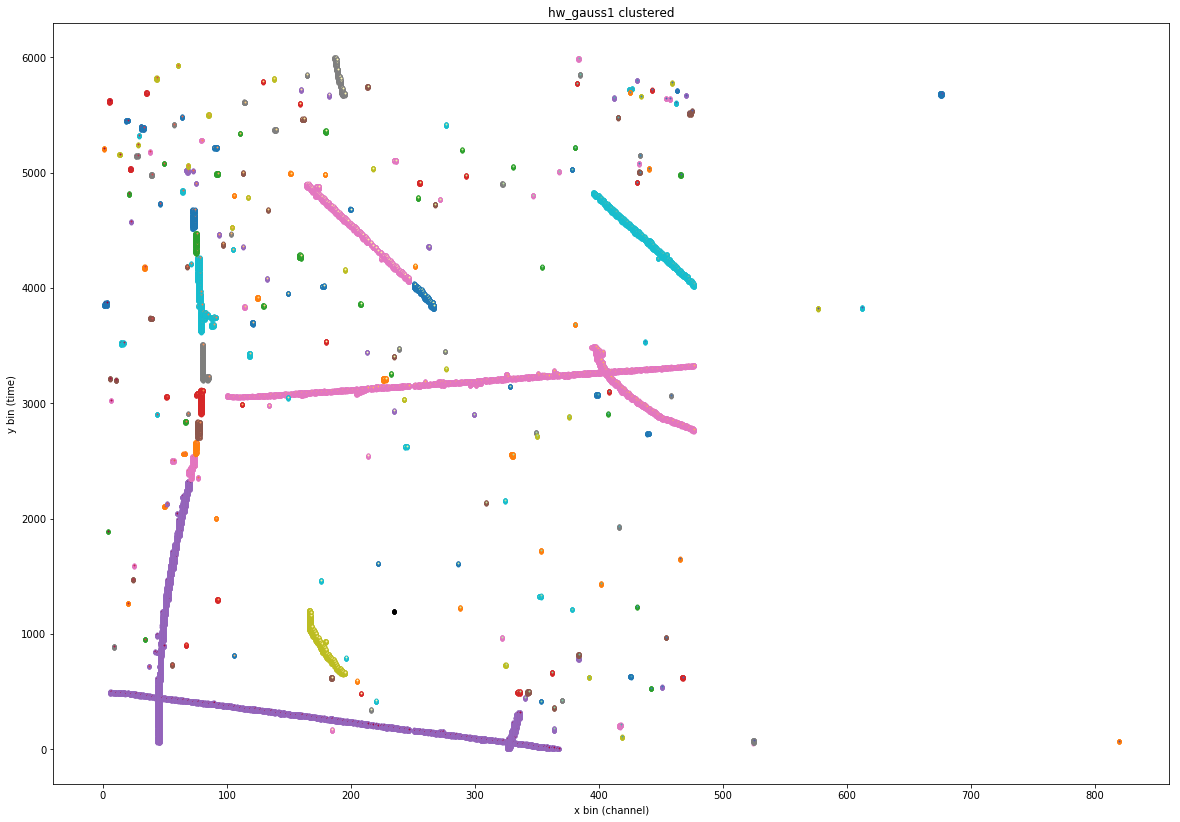

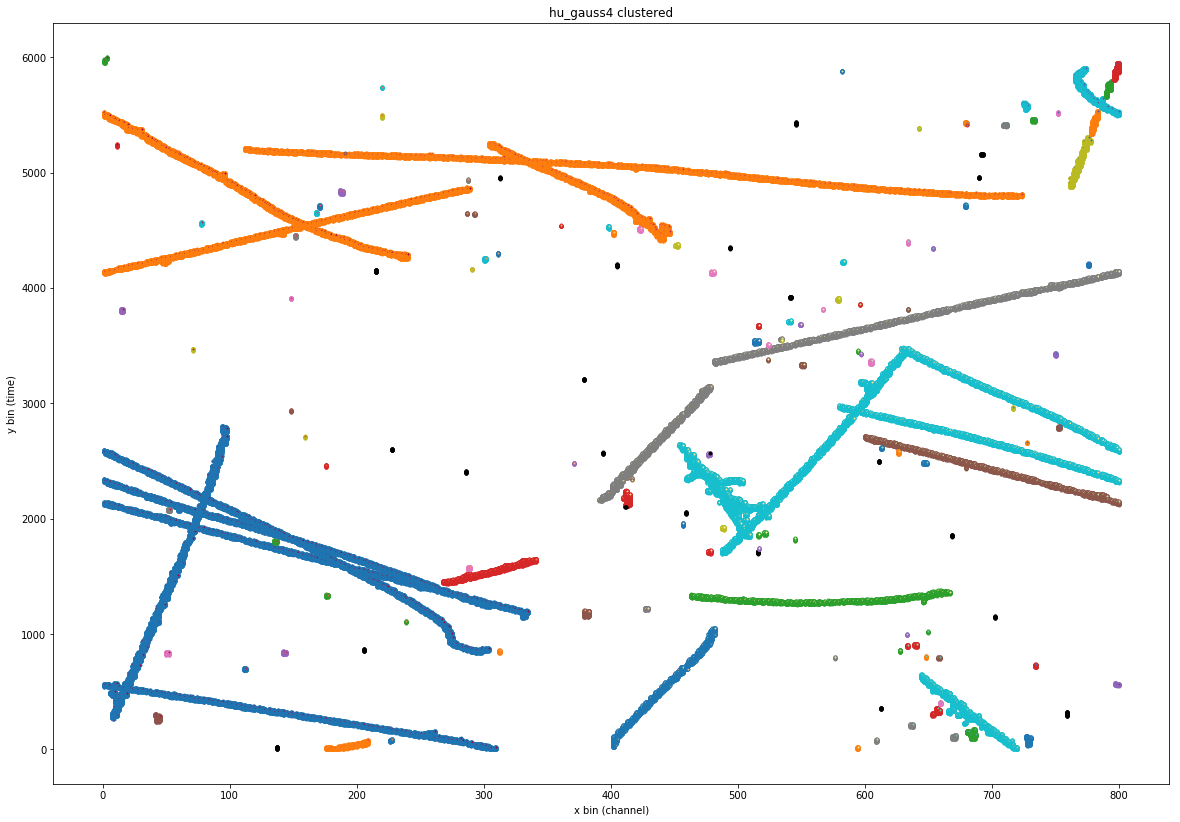

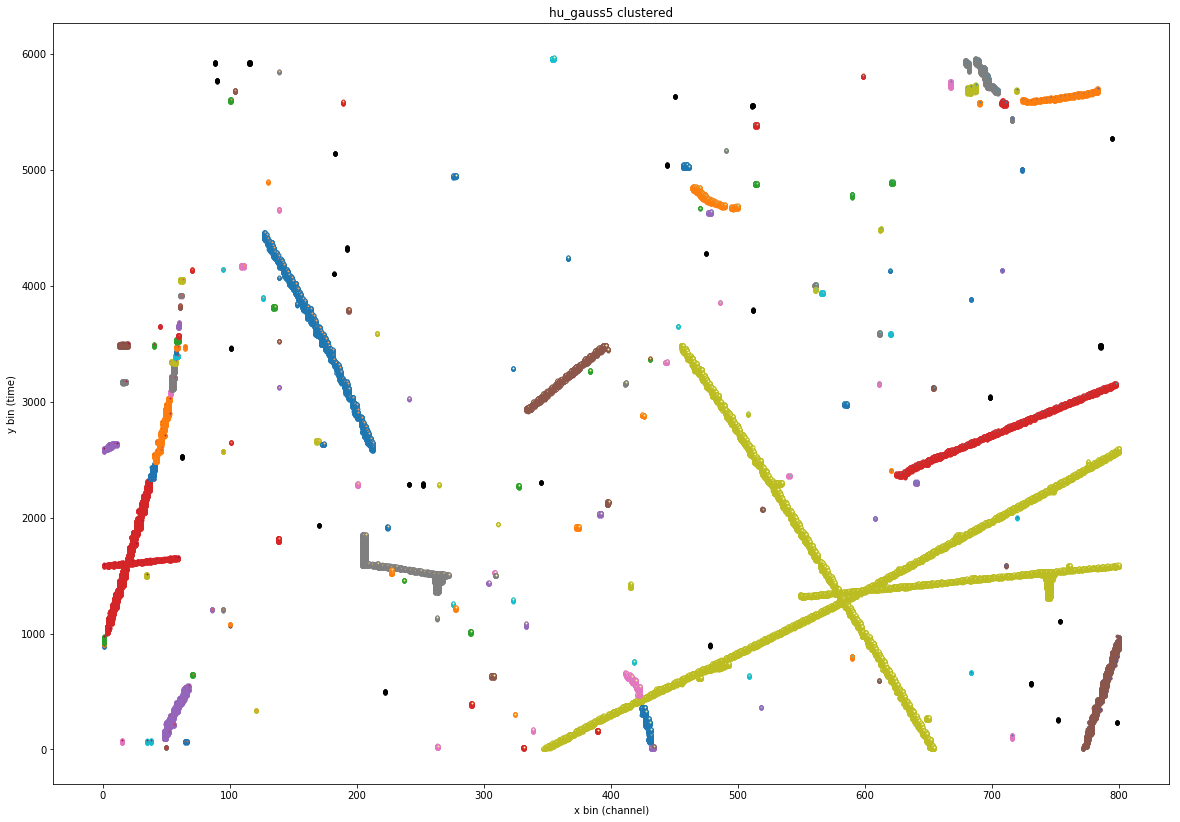

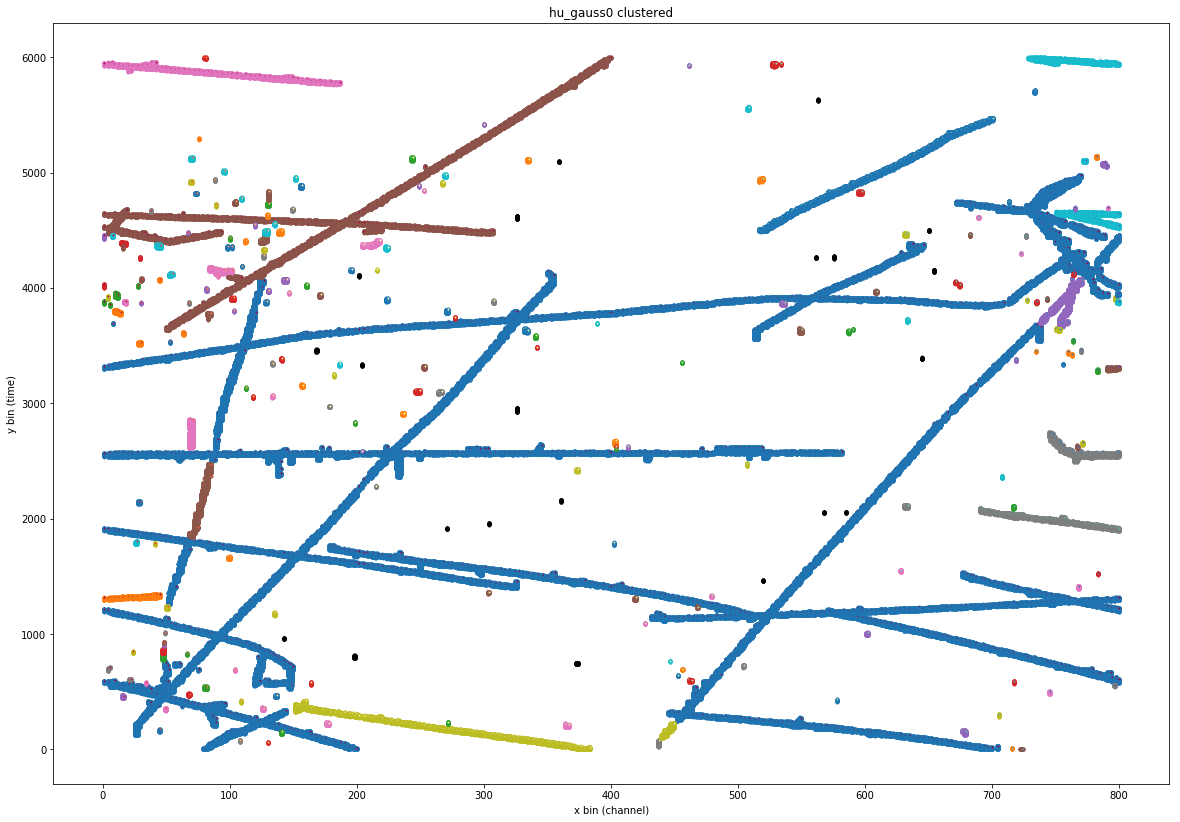

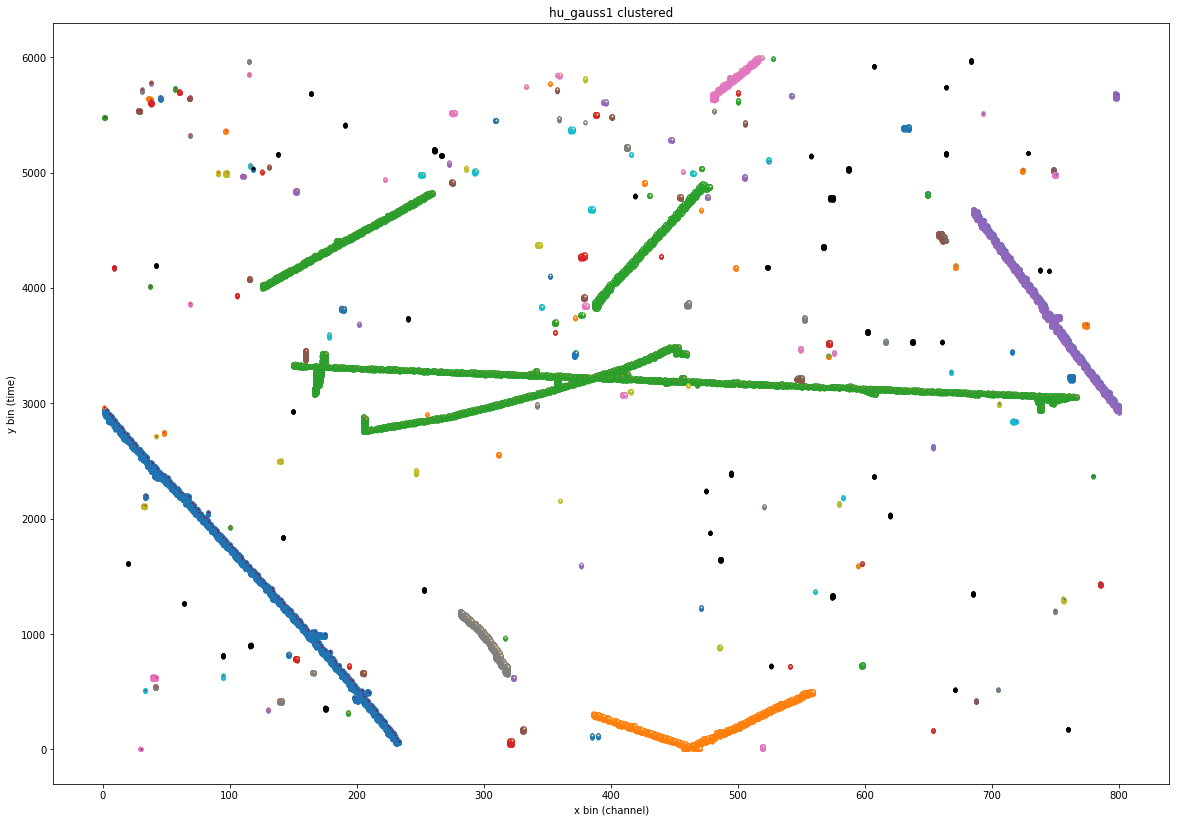

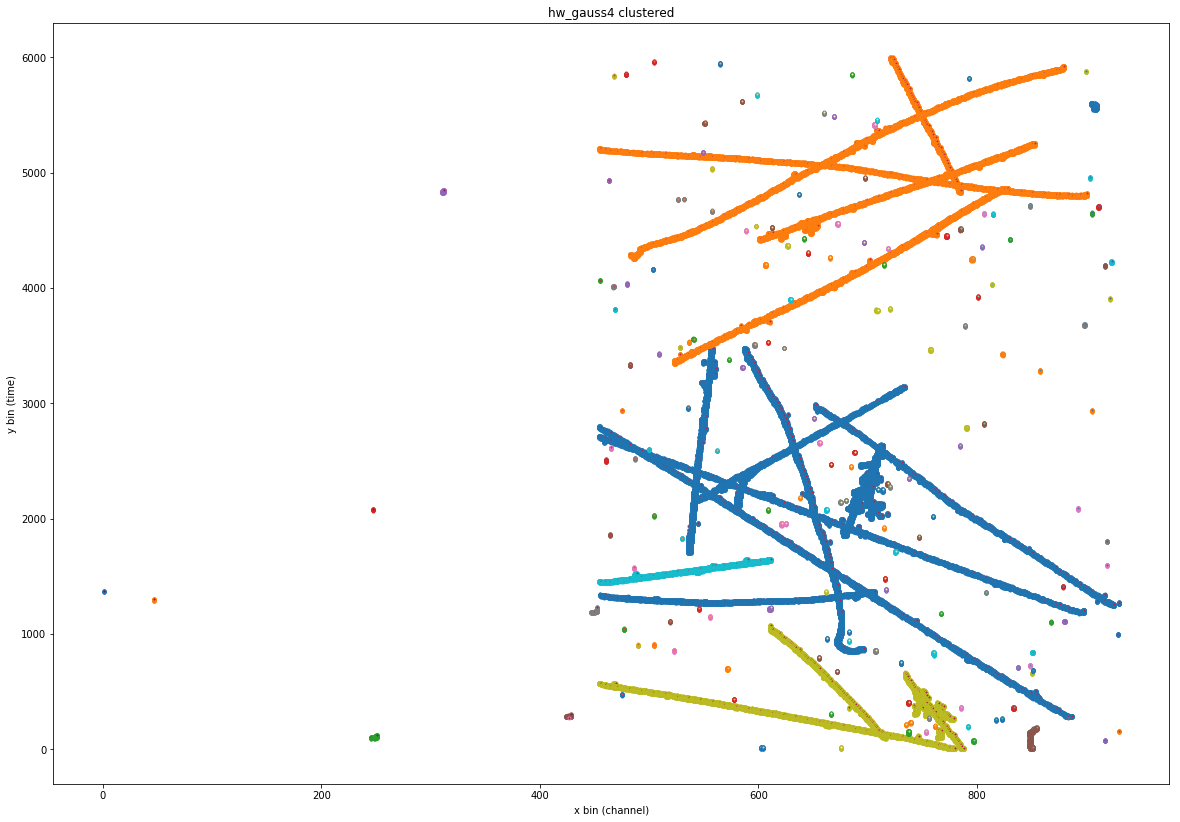

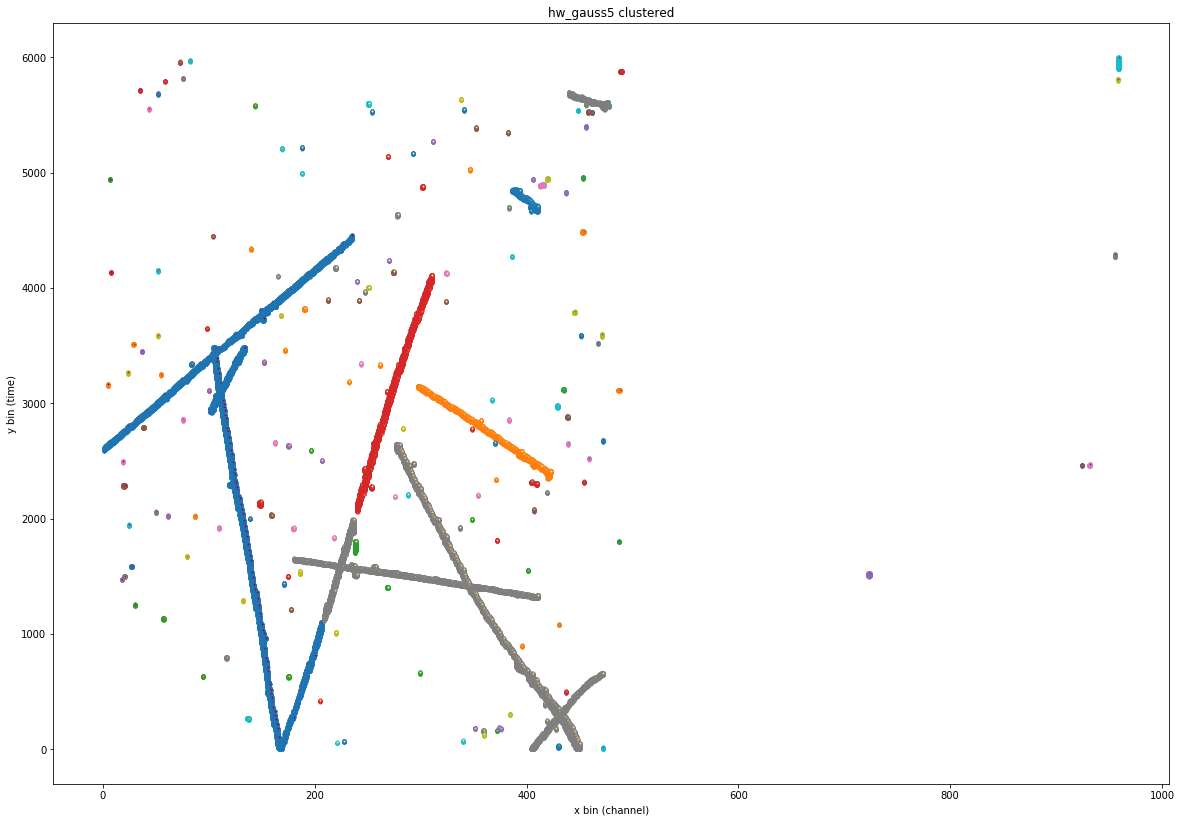

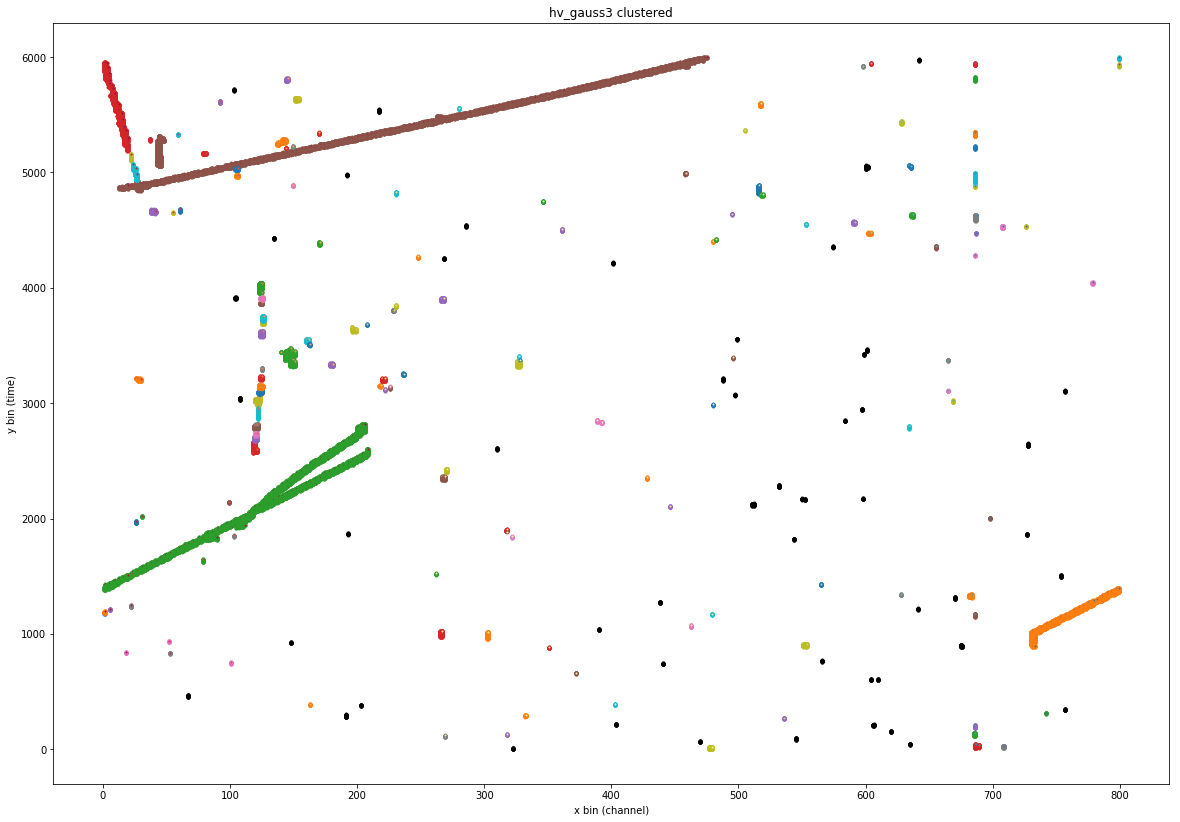

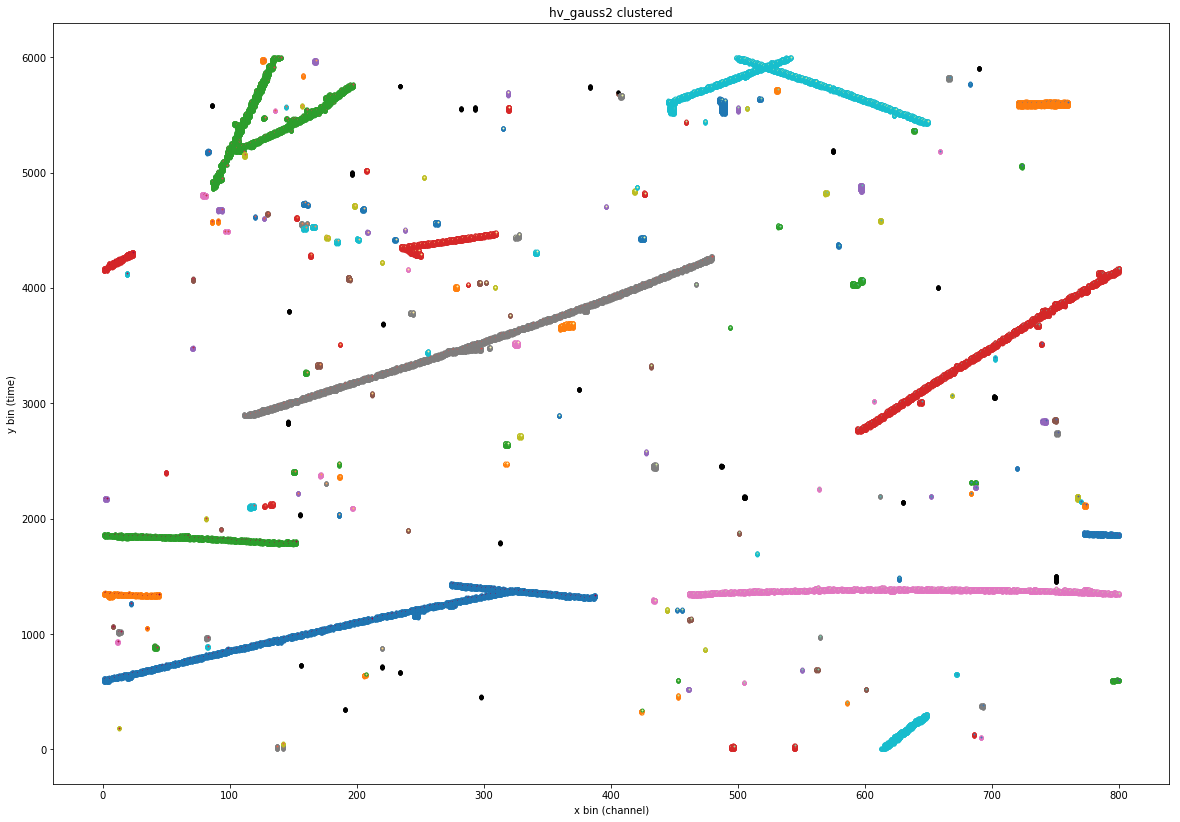

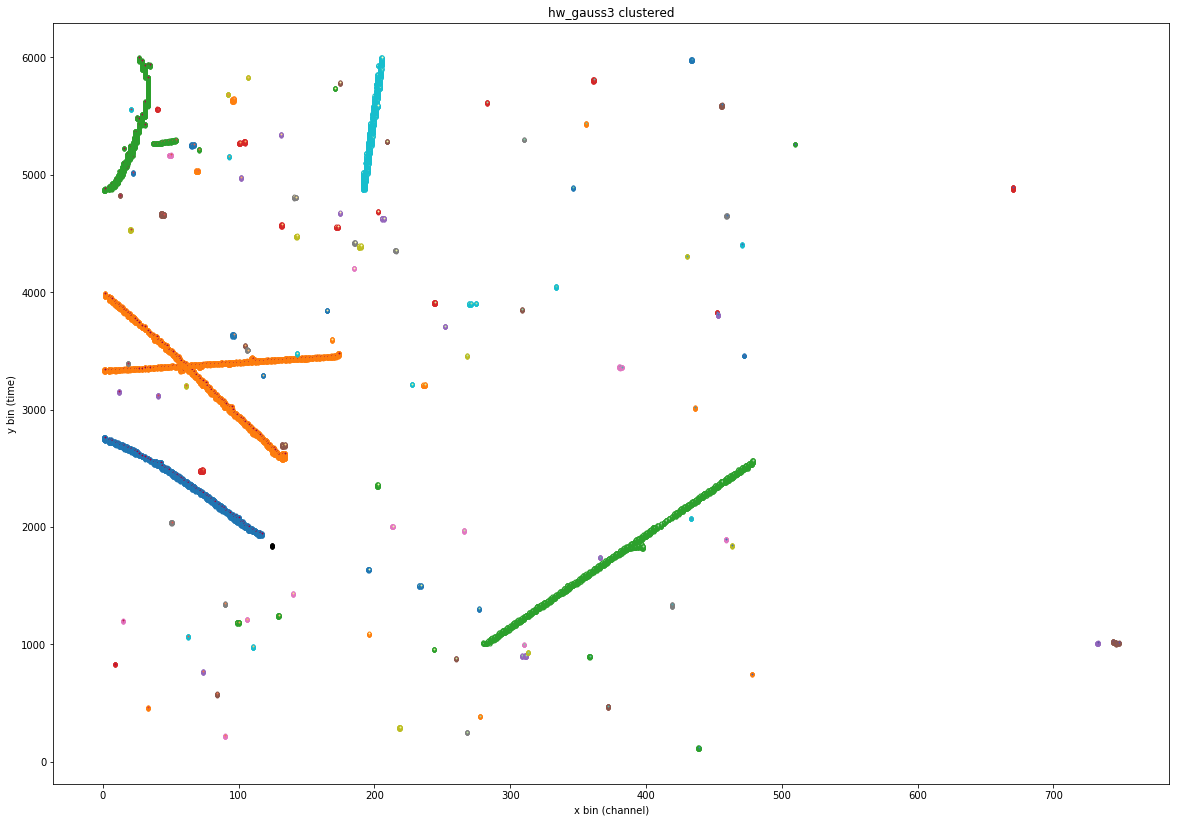

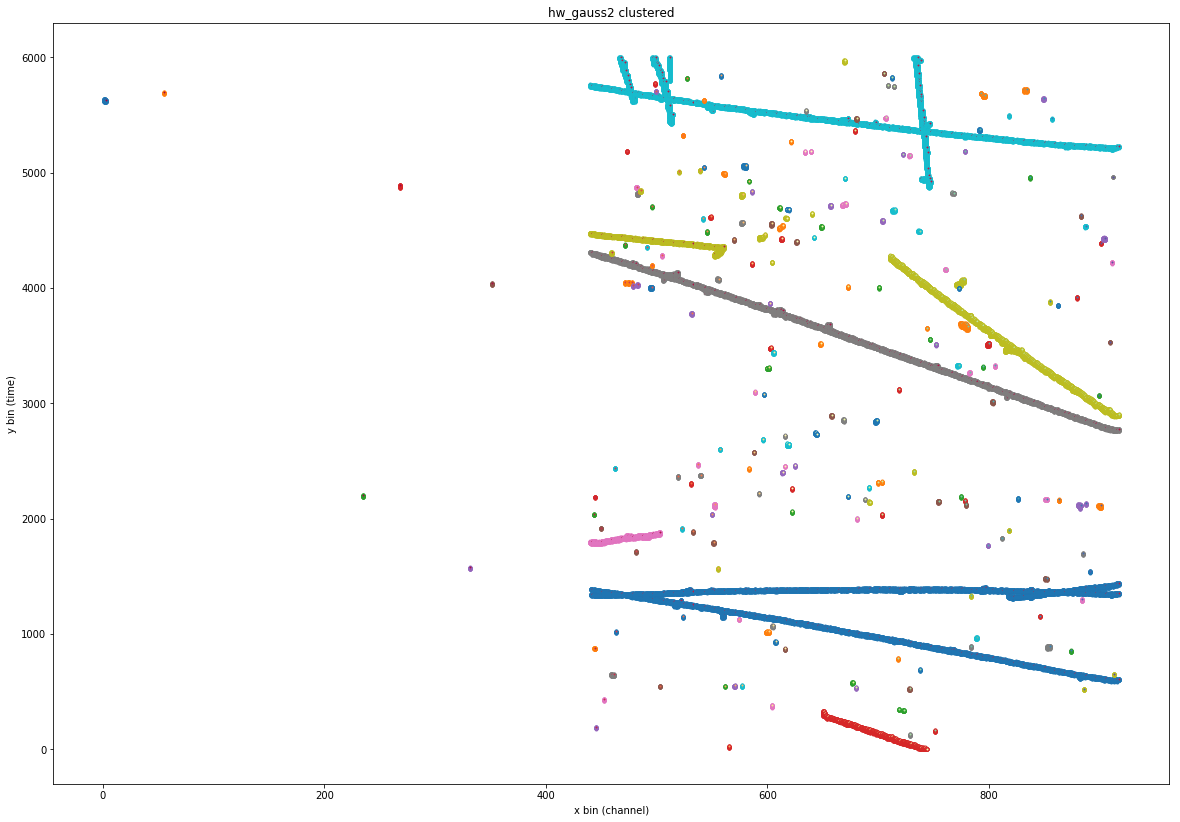

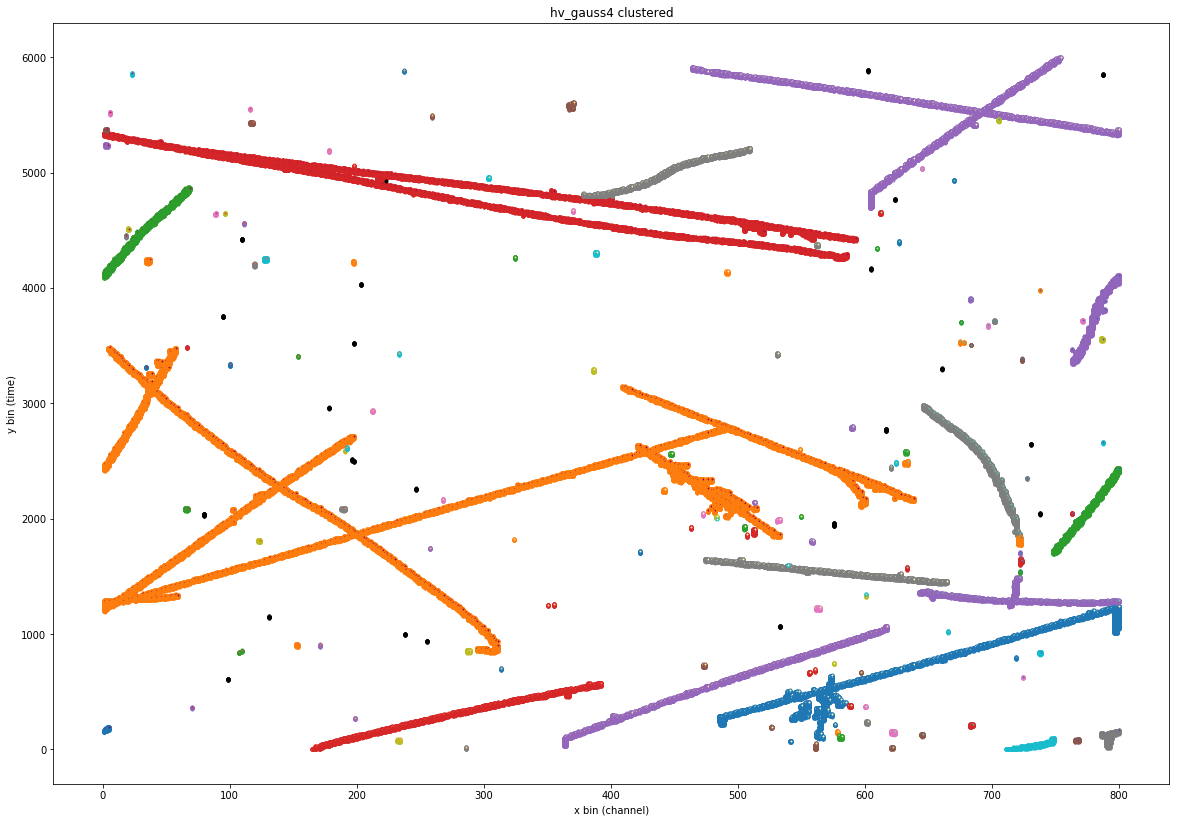

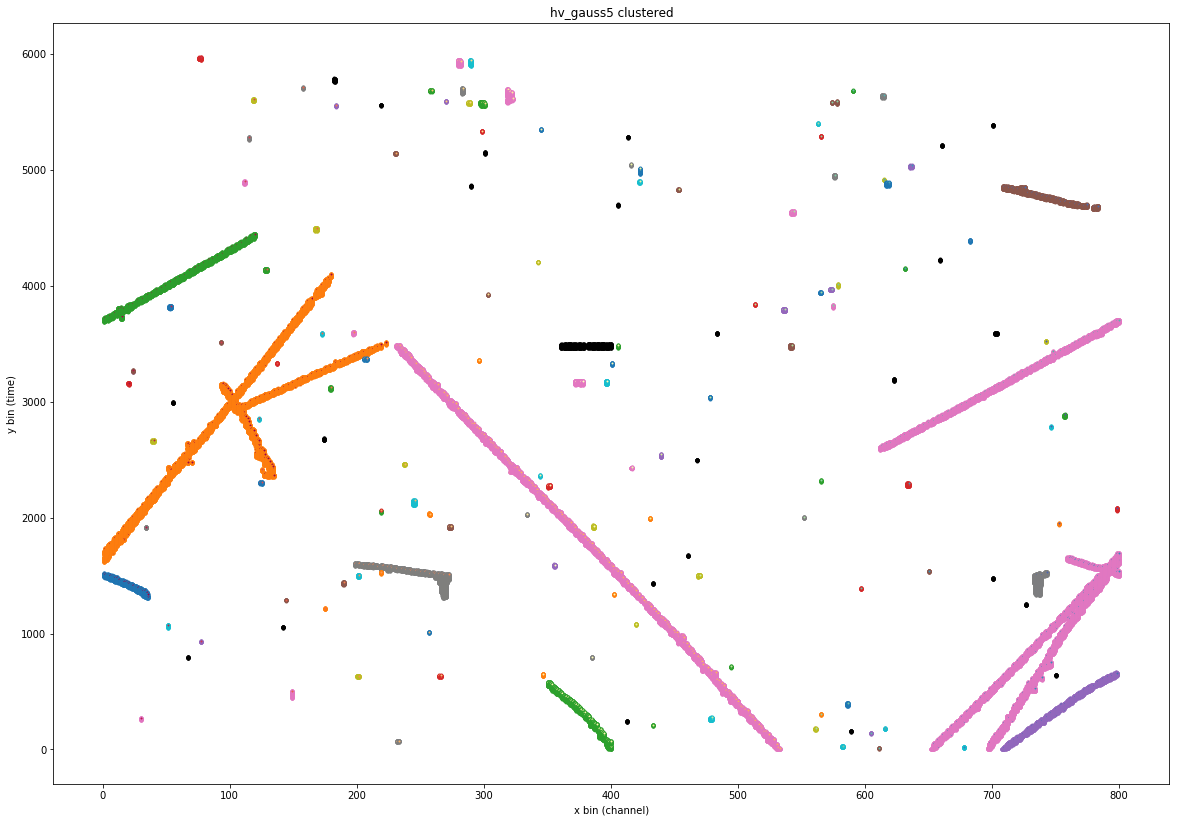

In [121]:
# Loop over all data (assume each orig file has a corresponding roi file)

results_dict7 = {}

for file in os.listdir("/Users/MatthewMan/root/protodune_results"):
    if fnmatch.fnmatch(file, '*orig.csv'):
        filename_header = file[0:9]
        
        print('---------------------------------------------------')
        print(filename_header, '\n')
        
        # calculate efficiency
        total_results, cnted_results = roi_efficiency(filename_header, save_plots=False, show_plots=True)
        
        results_dict7[filename_header] = np.append(total_results, cnted_results)

#print(results_dict)


In [122]:
## Average efficiency 

# [track_bins, track_weight, track_clusters, point_bins, point_weight, point_clusters]

results_sum = np.zeros(len(results_dict["hv_gauss0"]))

for results in results_dict.values(): # protodune-data-check-roi-22.root
    results_sum += results
for results in results_dict2.values(): # protodune-data-check-roi-6.root
    results_sum += results
for results in results_dict3.values(): # protodune-data-check-roi-9.root
    results_sum += results
for results in results_dict4.values(): # protodune-data-check-roi-5.root
    results_sum += results
for results in results_dict5.values(): # protodune-data-check-roi-10.root
    results_sum += results
for results in results_dict6.values(): # protodune-data-check-roi-14.root
    results_sum += results
for results in results_dict7.values(): # protodune-data-check-roi-11.root
    results_sum += results

avg_eff = np.divide(results_sum[6:], results_sum[:6])

print("Track Efficiencies (bin, weight, clusters)")
print(avg_eff[:3])
print("Point Efficiencies (bin, weight, clusters)")
print(avg_eff[3:])



Track Efficiencies (bin, weight, clusters)
[0.96575387 0.99660503 1.        ]
Point Efficiencies (bin, weight, clusters)
[0.91697749 0.97161827 0.88445053]


In [127]:
## Bins included

inc_percent = [0.412345, 0.331999, 0.387852, 0.369600, 0.356272, 0.386386, 0.395089]
avg_inc = np.mean(inc_percent)

print(avg_inc)



0.3770775714285714


In [126]:
## Average efficiency 

# [track_bins, track_weight, track_clusters, point_bins, point_weight, point_clusters]

results_sum = np.zeros(len(results_dict["hv_gauss0"]))

for results in results_dict4.values(): # protodune-data-check-roi-5.root
    results_sum += results

avg_eff = np.divide(results_sum[6:], results_sum[:6])

print("Track Efficiencies (bin, weight, clusters)")
print(avg_eff[:3])
print("Point Efficiencies (bin, weight, clusters)")
print(avg_eff[3:])



Track Efficiencies (bin, weight, clusters)
[0.9636601  0.99617182 1.        ]
Point Efficiencies (bin, weight, clusters)
[0.91408971 0.97104634 0.87597911]


### Test code below

Estimated number of clusters: 181 

track efficiency (bins):  0.970844712308127
track efficiency (weight):  0.9981925722915707
track efficiency (clusters):  1.0
point efficiency (bins):  0.9337476195249073
point efficiency (weight):  0.9839116722932953
point efficiency (clusters):  0.893491124260355 



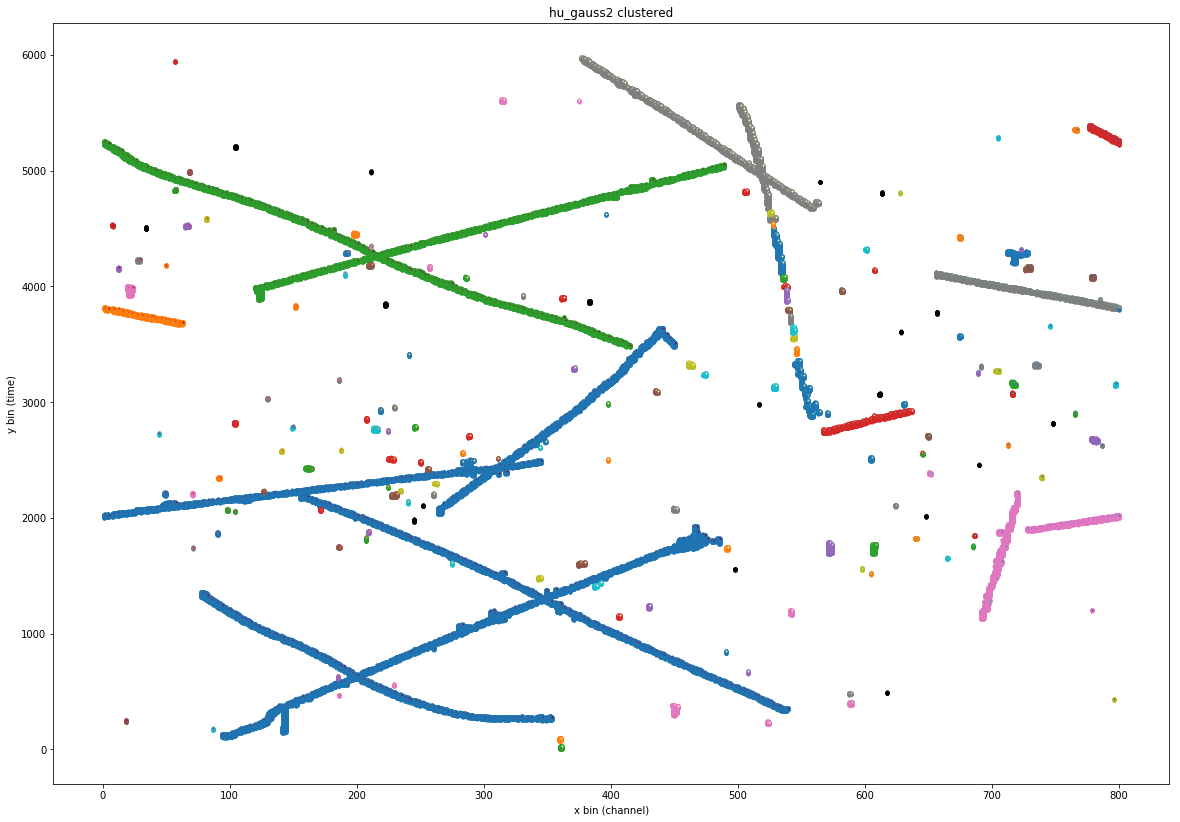

In [115]:
filename_header = "hu_gauss2"
total_results, cnted_results = roi_efficiency(filename_header, save_plots=False, show_plots=True)

In [86]:
test1 = [True, True, False, False]
test2 = [True, False, True, False]

test3 = np.logical_not(test1) 

print(test3)
print(test1 and test2)
print(np.logical_and(test1, test2))

[False False  True  True]
[True, False, True, False]
[ True False False False]


In [27]:
test1 = np.array([0.97050229, 0.99769564, 1.,         0.98273072, 0.99610441, 0.99926901])
test2 = np.array([0.97050229, 0.99769564, 1.,         0.98273072, 0.99610441, 0.99926901])*4
print(test1[:3])
print(test1[3:])
test3 = np.divide(test1, test2)
print(test3)

[0.97050229 0.99769564 1.        ]
[0.98273072 0.99610441 0.99926901]
[0.25 0.25 0.25 0.25 0.25 0.25]
